In [7]:
import numpy as np
from tools import load, split, estimate_derivative, train, test
import pickle
from matplotlib import pyplot as plt

In [8]:
n_hd = 10000
n_out = 6
k = 10
p = 0.03

file_train = 'mix_100_20_1'
file_test = 'mix_50_20_1'


train_data, train_sequence, train_times_sec, train_sequence_sec = load(file_train, reduced=True)
train_d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=train_data)
train_data = np.hstack((train_data, train_d_sensor_data))

test_data, test_sequence, test_times_sec, test_sequence_sec = load(file_test, reduced=True)
test_d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=test_data)
test_data = np.hstack((test_data, test_d_sensor_data))


W_hd, W_out = train(train_data, train_sequence, train_times_sec, train_sequence_sec,
                    n_hd=n_hd, n_out=n_out, k=k, p=p,
                    normalized=False, whitened=False)

train_acc = test(train_data, train_sequence, train_times_sec, train_sequence_sec,
                 W_hd, W_out,
                 n_hd=n_hd, n_out=n_out, k=k, integration_delay=0.,
                 normalized=False, whitened=False)

test_acc = test(test_data, test_sequence, test_times_sec, test_sequence_sec,
                W_hd, W_out,
                n_hd=n_hd, n_out=n_out, k=k, integration_delay=0.,
                normalized=False, whitened=False)

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}\n')

Train accuracy: 0.7817, Test accuracy: 0.6933



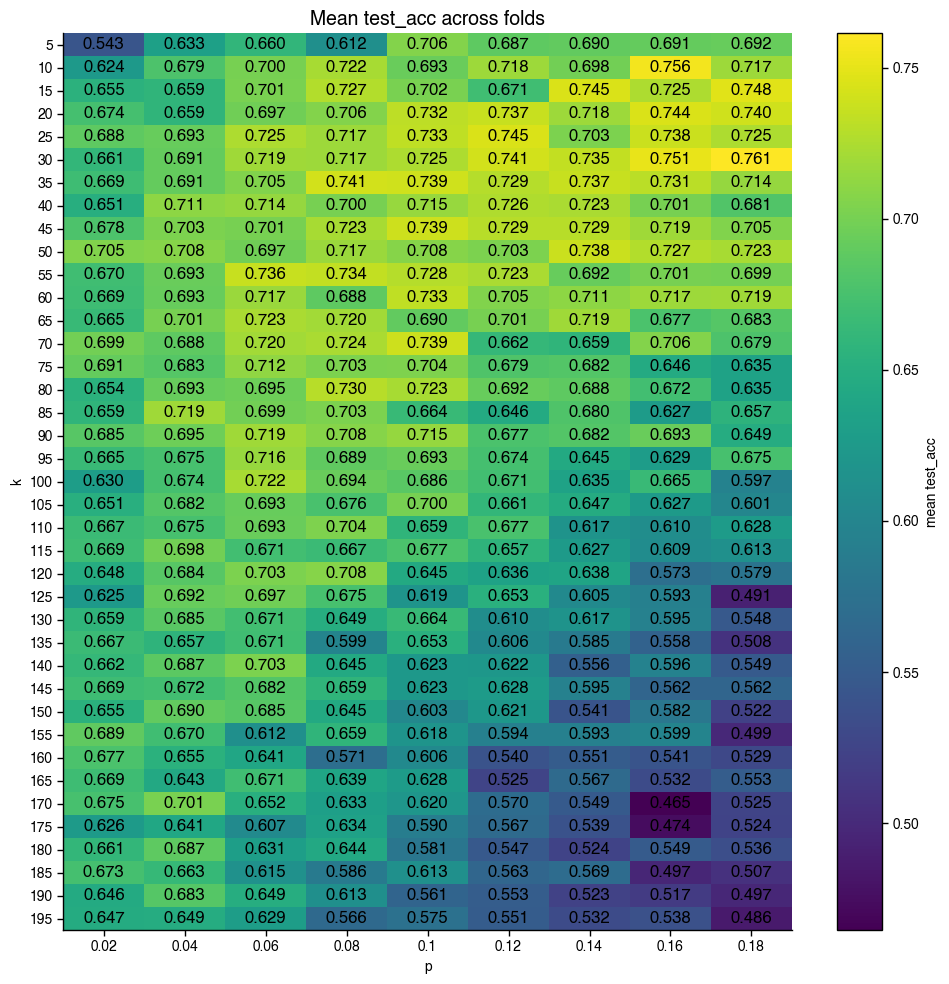

In [11]:
# --- load ---
with open("data/gridsearch_mix_100.pkl", "rb") as f:
    d = pickle.load(f)

k  = np.asarray(d["params"]["k"])
p  = np.asarray(d["params"]["p"])
ta = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute means across folds (no pandas) ---
# sort by (k, p)
idx = np.lexsort((p, k))       # primary k, then p
ks, ps, tas = k[idx], p[idx], ta[idx]

# find group starts where (k, p) changes
chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

# sums and counts per group → means
sums = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means = sums / counts

gk = ks[starts]   # k per group
gp = ps[starts]   # p per group

# --- put into a 2D grid (rows=k, cols=p) ---
ku = np.unique(k)
pu = np.unique(p)
grid = np.full((ku.size, pu.size), np.nan)

ki = np.searchsorted(ku, gk)
pi = np.searchsorted(pu, gp)
grid[ki, pi] = means

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(grid, aspect="auto")  # default colormap
ax.set_xticks(np.arange(pu.size)); ax.set_xticklabels(pu)
ax.set_yticks(np.arange(ku.size)); ax.set_yticklabels(ku)
ax.set_xlabel("p")
ax.set_ylabel("k")
ax.set_title("Mean test_acc across folds")

# annotate cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if np.isfinite(grid[i, j]):
            ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="mean test_acc")
plt.tight_layout()
plt.show()

In [12]:
k       = np.asarray(d["params"]["k"])
p       = np.asarray(d["params"]["p"])
n_fold  = np.asarray(d["params"]["n_fold"])
testacc = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute mean across folds ---
idx = np.lexsort((p, k))           # sort by k, then p
ks, ps, tas = k[idx], p[idx], testacc[idx]

chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

sums   = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means  = sums / counts

gk = ks[starts]
gp = ps[starts]

# --- pick best group by highest mean ---
best_group = int(np.nanargmax(means))
best_k = gk[best_group]
best_p = gp[best_group]

# all folds at those params
mask = (k == best_k) & (p == best_p)
best_vals = testacc[mask]
best_folds = n_fold[mask]

# best single-fold at those params
best_single_idx = int(np.nanargmax(best_vals))
best_n_fold = best_folds[best_single_idx]

# --- print in requested style (adapted: p instead of N_pot, no t_delay available) ---
print(
    f"Best params → k={best_k}, p={best_p}\n"
    f"Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
    f"Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}"
)

Best params → k=30, p=0.18
Highest mean test accuracy: 0.7613 ± 0.0254 (n=5)
Highest single-fold test accuracy at those params: 0.8100, n_fold=3
